In [1]:
import gower
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.random_projection import GaussianRandomProjection
import xgboost as xgb

In [2]:
blockSizes = ['16', '32', '64']
hayStats = ['cold', 'l1cap', 'l2cap', 'totref']
benches = ['Resnet50', 'FasterRCNN', 'Googlenet', 'SYNCNET0', 
           'SYNCNET1', 'SYNCNET2', 'SYNCNET3', 'SYNCNET4', 'SYNCNET5']

stats_headers = ['Layer']
for ps in hayStats:
    for bs in blockSizes:
        stats_headers.append(ps + bs)
stats_headers.append('Nan')

fstats = []
for bench in benches:
    shapes = pd.read_csv('../conv_nets/' + bench + '.csv')
    stats = pd.read_csv(bench + '.haystack.csv', names=stats_headers)
    stats = stats.drop('Nan', axis=1)
    stats = stats.merge(shapes, left_on='Layer', right_on='Layer name')
    stats = stats.dropna(axis=1, how='all')
    fstats.append(stats)
    
stats = pd.concat(fstats, ignore_index=True)

stats

,Layer,cold16,cold32,cold64,l1cap16,l1cap32,l1cap64,l2cap16,l2cap32,l2cap64,...,totref64,Layer name,IFMAP Height,IFMAP Width,Filter Height,Filter Width,Channels,Num Filter,Strides,Unnamed: 8
0,Conv1,-,-,-,-,-,-,-,-,-,...,-,Conv1,224,224,7,7,3,64,2,NaN
1,CB2a_1,25216,25120,25096,37632,12544,0,0,12544,0,...,3612672,CB2a_1,56,56,1,1,64,64,1,NaN
2,CB2a_2,27152,26288,26072,192304,64496,25520,40368,13456,0,...,29302784,CB2a_2,56,56,3,3,64,64,1,NaN
3,CB2a_3,63232,62848,62752,188160,87808,37632,0,87808,37632,...,14450688,CB2a_3,56,56,1,1,64,256,1,NaN
4,CB2s,63232,62848,62752,188160,87808,37632,0,87808,37632,...,14450688,CB2s,56,56,1,1,64,256,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,Conv998,-,-,-,-,-,-,-,-,-,...,-,Conv998,7,7,7,7,24,1632,1,NaN
5464,Conv999,94334,33134,-,19966826,9422658,-,86394,37026,-,...,-,Conv999,7,7,5,5,1632,128,1,NaN
5465,Conv1000,554,506,-,0,0,-,0,0,-,...,-,Conv1000,7,7,1,1,128,32,1,NaN
5466,Conv1001,14450,5042,-,38126,5070,-,0,0,-,...,-,Conv1001,7,7,7,7,32,512,1,NaN


In [3]:
yheader = "l1cap"

inds_train, inds_test = train_test_split(np.arange(len(stats.index)), test_size=0.2, random_state=18)

h,r,c,k,b,s,i = [],[],[],[],[],[],[]
cold,l1cap,l2cap,y = [],[],[],[]

bx = []
for (index, row) in stats.iterrows():

    blks, vals = [], []
    for bs in blockSizes:
        if row[yheader + bs] == '-':
            continue
        
        h.append(float(row[' IFMAP Height']))
        r.append(float(row[' Filter Width']))
        c.append(float(row[' Channels']))
        k.append(float(row[' Num Filter']))
        b.append(float(bs))
        blks.append(float(bs))
        vals.append(float(float(row[yheader + bs]) / float(row['totref' + bs])))
        s.append(float(row[' Strides']))
        i.append(index)
        
        y.append(float(row[yheader + bs]) / float(row['totref' + bs]))
#         print(row['Layer'], bs, row[yheader + bs])
#     print("_____")
    if len(vals) == 3:
        ind = vals.index(min(vals))
#         print(blks[ind])
        bx.append(blks[ind])


X = pd.DataFrame({'H':h, 'R':r, 'C':c, 'K':k, 'b':b, 's':s})
Xi = pd.DataFrame({'H':h, 'R':r, 'C':c, 'K':k, 'b':b, 's':s, 'i':i})
print(bx.count(16.0), bx.count(32.0), bx.count(64.0))

395 149 1304


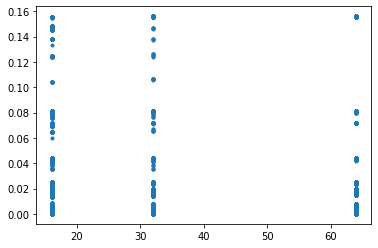

In [4]:
px,py = [],[]
for i in range(len(b)):
    px.append(b[i])
    py.append(y[i])
    
plt.plot(b,y, '.')

In [5]:
(num_examples, num_features) = X.shape
_X = gower.gower_matrix(X)
proj = GaussianRandomProjection(n_components = num_features, eps = 0.05)
Xtransformed = proj.fit_transform(_X)

# inds = np.arange(len(y))
# X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(Xtransformed, y, inds, test_size=0.3, random_state=18)

X_train, X_test, y_train, y_test, itrain, itest = [], [], [], [], [], []
for (index,row) in Xi.iterrows():
    c = row['i']
    if c in inds_train:
        X_train.append(Xtransformed[index])
        y_train.append(y[index])
        itrain.append(index)
    elif c in inds_test:
        X_test.append(Xtransformed[index])
        y_test.append(y[index])
        itest.append(index)
    else:
        print("WHAT")

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

print(len(X_train), len(y_train), len(X_test), len(y_test))

6922 6922 1842 1842


In [6]:
param = {'max_depth':5, 'eta':0.4, 'objective':'reg:squarederror'}
num_round = 10
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

predicted = {}

for (x,y,i) in zip(preds, y_test, itest):
    h = X.loc[i, 'H']
    r = X.loc[i, 'R']
    c = X.loc[i, 'C']
    k = X.loc[i, 'K']
    b = X.loc[i, 'b']
    s = X.loc[i, 's']
    
    dictIndex = "%.0f_%.0f_%.0f_%.0f_%.0f" % (h,r,c,k,s)
    if dictIndex not in predicted:
        predicted[dictIndex] = {b : [x,y]}
    else:
        predicted[dictIndex][b] = [x,y]

# for entry in predicted:
#     print(entry, predicted[entry])

In [7]:
total,minmatches,ordermatches = 0,0,0
m1, m2 = 0, 0
for shape in predicted:
    p = predicted[shape]
    x1,x2 = [],[]
    for b in p:
        x1.append(p[b][0])
        x2.append(p[b][1])

#     if len(x1) < 3:
#         continue

    total += 1
    if (x1.index(min(x1)) == x2.index(min(x2))):
        minmatches += 1
        if (x1.index(max(x1)) == x2.index(max(x2))):
            ordermatches += 1
#     else:
#         print(shape, predicted[shape])
        
    m1 += x2[x1.index(min(x1))]
    m2 += x2[x2.index(min(x2))]
    
#     print(x1.index(min(x1)), x2.index(min(x2)), shape, predicted[shape])
        
print(minmatches, ordermatches, total, m1, m2, m1/m2)

389 340 645 15.665380336185622 15.207450094857764 1.0301122304180832


In [8]:
y_test

[0.0035511363636363635,
 0.003216911764705882,
 0.0026041666666666665,
 0.0026563934397288327,
 0.002523530964109782,
 0.0022605360637405645,
 0.007339015151515152,
 0.006893382352941176,
 0.006076388888888889,
 0.0026563934397288327,
 0.002523530964109782,
 0.0022605360637405645,
 0.007473562906724512,
 0.006880422993492408,
 0.0056941431670282,
 0.002940619939449412,
 0.0028163064141378583,
 0.002658458094305303,
 0.0077300896624472575,
 0.007153217299578059,
 0.0065625,
 0.0077300896624472575,
 0.007153217299578059,
 0.005999472573839662,
 0.0077300896624472575,
 0.007153217299578059,
 0.0065625,
 0.0077300896624472575,
 0.007153217299578059,
 0.0065625,
 0.0077300896624472575,
 0.007153217299578059,
 0.0065625,
 0.0077300896624472575,
 0.007153217299578059,
 0.0065625,
 0.007621343085106383,
 0.007330452127659574,
 0.006748670212765958,
 0.007058244410569106,
 0.007447281504065041,
 0.006891514227642276,
 0.0014556024814243657,
 0.0032770222907612507,
 0.007757736926959203,
 0.0070